# Importing Libraries

In [24]:
# Import necessary libraries
import re
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import joblib
import os
from glob import glob
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

# Dataset Loading and Initial Validation

In [25]:
# Define the file path as a parameter to make it reusable and adaptable
file_path = 'IMDB_Dataset.csv'

# Load the dataset with error handling and extended data exploration
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please check the file path.")
except pd.errors.EmptyDataError:
    print("Error: The file is empty. Please provide a valid dataset.")
except pd.errors.ParserError:
    print("Error: The file contains parsing errors. Please check the file format.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
else:
    # Confirm successful loading and display initial data information
    print("Dataset successfully loaded!")
    print("\nFirst few rows of the dataset:")
    display(df.head())

    # Check for missing values
    missing_values = df.isnull().sum()
    print("\nMissing values in each column:")
    print(missing_values[missing_values > 0])

    # Renaming columns for consistency if necessary
    if {'review', 'sentiment'}.issubset(df.columns):
        df = df[['review', 'sentiment']]
        print("\nSelected 'review' and 'sentiment' columns for analysis.")
    else:
        raise ValueError("Error: 'review' and 'sentiment' columns are required but missing in the dataset.")
    
    # Display class distribution if present
    if 'sentiment' in df.columns:
        print("\nSentiment class distribution:")
        print(df['sentiment'].value_counts(normalize=True) * 100)

    # Validate sentiment values for expected classes
    if not set(df['sentiment'].unique()).issubset({'positive', 'negative'}):
        raise ValueError("Error: Sentiment column contains unexpected values. Expected 'positive' or 'negative' only.")


Dataset successfully loaded!

First few rows of the dataset:


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive



Missing values in each column:
Series([], dtype: int64)

Selected 'review' and 'sentiment' columns for analysis.

Sentiment class distribution:
positive    50.0
negative    50.0
Name: sentiment, dtype: float64


# Text Preprocessing

In [26]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Text preprocessing function
def preprocess(text):
    # Validate that text is a string
    if not isinstance(text, str):
        return ""
    
    # Convert text to lowercase and normalize special characters
    text = text.lower()
    text = text.encode("ascii", "ignore").decode()  # Remove unicode characters
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove punctuation and digits
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r'\d+', '', text)
    
    # Tokenize, remove stopwords, and lemmatize
    tokens = word_tokenize(text)
    cleaned_tokens = [
        lemmatizer.lemmatize(word) 
        for word in tokens if word not in stop_words
    ]
    
    # Join tokens back into a string
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

# Apply the preprocessing function to the DataFrame
df['cleaned_text'] = df['review'].apply(preprocess)

# Display cleaned data and sample
print("Sample of preprocessed text:")
display(df[['review', 'cleaned_text']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\srinivasareddyb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\srinivasareddyb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\srinivasareddyb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Sample of preprocessed text:


,review,cleaned_text
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,wonderful little production br br filming tech...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


# Data Splitting and Label Encoding

In [27]:
# Ensure 'cleaned_text' and 'sentiment' columns are available
if {'cleaned_text', 'sentiment'}.issubset(df.columns):
    # Rename 'sentiment' to 'label' for clarity if desired
    df = df.rename(columns={'sentiment': 'label'})
    
    # Convert labels to binary values: 1 for 'positive' and 0 for 'negative'
    df['label'] = df['label'].map({'positive': 1, 'negative': 0})
    
    # Define test size, validation size, and random seed for reproducibility
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    
    # Perform a stratified split to maintain class distribution in the train/test sets
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            df['cleaned_text'],
            df['label'],
            test_size=TEST_SIZE,
            random_state=RANDOM_STATE,
            stratify=df['label']
        )
        
        # Reset indices of the train and test sets for consistency
        X_train = X_train.reset_index(drop=True)
        X_test = X_test.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        y_test = y_test.reset_index(drop=True)
        
        print("Train-test split successful!")
        print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
        print(f"Class distribution in training set:\n{y_train.value_counts(normalize=True) * 100}")
        print(f"Class distribution in test set:\n{y_test.value_counts(normalize=True) * 100}")
        
    except ValueError as e:
        print("Error during train-test split:", e)
else:
    print("Error: 'cleaned_text' and 'sentiment' columns are required in the dataset.")


Train-test split successful!
Training samples: 40000, Testing samples: 10000
Class distribution in training set:
1    50.0
0    50.0
Name: label, dtype: float64
Class distribution in test set:
0    50.0
1    50.0
Name: label, dtype: float64


# TF-IDF Vectorization and Feature Extraction

In [28]:
# Ensure output directory exists
output_dir = 'model'
os.makedirs(output_dir, exist_ok=True)

# Define TF-IDF Vectorizer Parameters
MAX_FEATURES = 10000            # Increase max features for a richer representation
NGRAM_RANGE = (1, 2)            # Capture both unigrams and bigrams
MIN_DF = 5                      # Minimum document frequency
MAX_DF = 0.75                   # Ignore overly common terms

# Initialize TF-IDF Vectorizer with custom parameters
vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=NGRAM_RANGE,
    min_df=MIN_DF,
    max_df=MAX_DF,
    stop_words='english',
    sublinear_tf=True  # Applies sublinear scaling for more balanced term frequency
)

try:
    # Fit and transform the training data using preprocessed text
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Transform the test data using the same vectorizer
    X_test_vec = vectorizer.transform(X_test)
    
    # Display vectorization details
    print("Vectorization successful!")
    print(f"Training set dimensions: {X_train_vec.shape}")
    print(f"Test set dimensions: {X_test_vec.shape}")
    
    # Display feature names to understand the vocabulary (top 10 terms)
    feature_names = vectorizer.get_feature_names_out()
    print(f"Sample features: {feature_names[:10]}")
    
    # Save the vectorizer with a timestamp for version control
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    vectorizer_path = os.path.join(output_dir, f'tfidf_vectorizer_{timestamp}.pkl')
    joblib.dump(vectorizer, vectorizer_path)
    print(f"TF-IDF Vectorizer saved to '{vectorizer_path}'")
    
except ValueError as e:
    print("Error during vectorization:", e)


Vectorization successful!
Training set dimensions: (40000, 10000)
Test set dimensions: (10000, 10000)
Sample features: ['aaron' 'abandon' 'abandoned' 'abbott' 'abc' 'ability' 'able' 'able make'
 'aboard' 'abomination']
TF-IDF Vectorizer saved to 'model\tfidf_vectorizer_20241107-153511.pkl'


# Model Training with Logistic Regression

In [29]:

# Ensure output directory exists
output_dir = 'model'
os.makedirs(output_dir, exist_ok=True)

# Logistic Regression parameters
MODEL_PARAMS = {
    'solver': 'liblinear',  # Effective for binary classification
    'penalty': 'l2',        # L2 regularization for generalization
    'C': 0.5,               # Reduced regularization strength to mitigate overfitting
    'max_iter': 200,        # Increased max iterations for convergence
    'random_state': 42      # For reproducibility
}

# Initialize the Logistic Regression model
model = LogisticRegression(**MODEL_PARAMS)

try:
    # Cross-validation to evaluate model performance on training data
    cv_scores = cross_val_score(model, X_train_vec, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation Accuracy Scores: {cv_scores}")
    print(f"Average CV Accuracy: {cv_scores.mean():.4f}")

    # Train the model on the full training set
    model.fit(X_train_vec, y_train)
    print("Model training successful!")

    # Evaluate the model on test data with multiple metrics
    y_pred = model.predict(X_test_vec)
    test_accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
    
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Optional: Save the trained model with timestamp for version control
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    model_path = os.path.join(output_dir, f'sentiment_logistic_model_{timestamp}.pkl')
    joblib.dump(model, model_path)
    print(f"Model saved to '{model_path}'")
    
except Exception as e:
    print("Error during model training or evaluation:", e)


Cross-validation Accuracy Scores: [0.88975  0.88075  0.8865   0.882125 0.881125]
Average CV Accuracy: 0.8841
Model training successful!
Test Accuracy: 0.8920
Precision: 0.8824
Recall: 0.9046
F1 Score: 0.8933
Model saved to 'model\sentiment_logistic_model_20241107-153524.pkl'


# Model Evaluation and Performance Metrics Visualization

Accuracy: 0.8920
Precision: 0.8824
Recall: 0.9046
F1 Score: 0.8933

Classification Report:
               precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      5000
    Positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



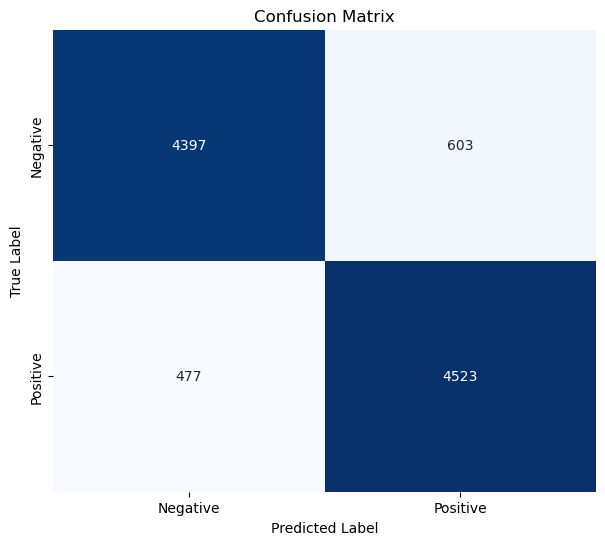

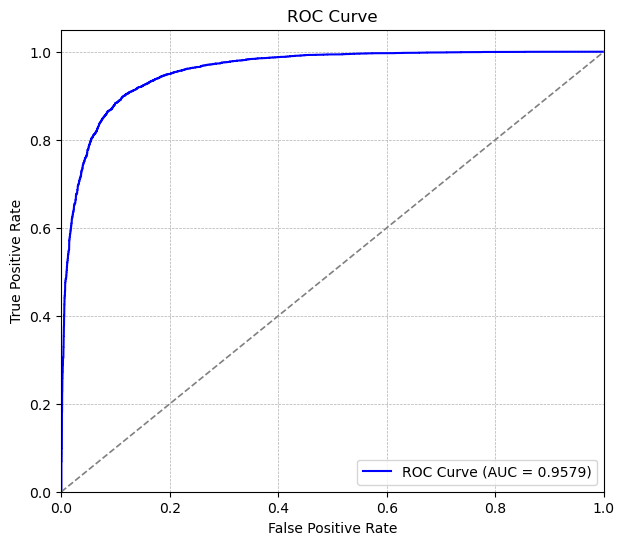

In [30]:
# Ensure predictions can be made on the test set
try:
    # Predict on the test set
    y_pred = model.predict(X_test_vec)
    
    # Evaluate model performance using multiple metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    
    # Display performance metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Display detailed classification report
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
    
    # Confusion Matrix Visualization
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    # ROC Curve and AUC Score
    y_pred_prob = model.predict_proba(X_test_vec)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # ROC Curve Visualization with AUC
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1.2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()
    
except Exception as e:
    print("Error during model evaluation:", e)


In [31]:
# Load the latest model and vectorizer based on timestamp
def load_latest_model_and_vectorizer():
    try:
        # Get list of saved models and vectorizers with timestamps in the 'model' directory
        model_files = sorted(glob('model/sentiment_logistic_model_*.pkl'))
        vectorizer_files = sorted(glob('model/tfidf_vectorizer_*.pkl'))
        
        # Ensure at least one model and vectorizer exist
        if not model_files or not vectorizer_files:
            raise FileNotFoundError("No model or vectorizer files found in the 'model' directory.")
        
        # Load the latest model and vectorizer files based on their filenames
        model = joblib.load(model_files[-1])
        vectorizer = joblib.load(vectorizer_files[-1])
        print("Latest model and vectorizer loaded successfully.")
        return model, vectorizer
    
    except FileNotFoundError as e:
        print("Error loading model or vectorizer:", e)
        return None, None

model, vectorizer = load_latest_model_and_vectorizer()

def analyze_sentiment_with_concerned_words(text, top_n=5):
    """
    Analyze sentiment of input text and display the top words influencing the sentiment.
    """
    if model is None or vectorizer is None:
        print("Model or vectorizer not loaded. Please check file paths.")
        return None

    try:
        # Preprocess and vectorize the input text
        processed_text = preprocess(text)  # Using previously defined preprocess function
        vectorized_text = vectorizer.transform([processed_text])
        
        # Predict sentiment
        prediction = model.predict(vectorized_text)[0]
        sentiment = "Positive" if prediction == 1 else "Negative"
        
        # Get feature coefficients for each word in the text
        words = vectorizer.get_feature_names_out()
        coefficients = model.coef_[0]
        
        # Find indices of words in the input text and get their coefficients
        feature_indices = vectorized_text.nonzero()[1]
        feature_words = [(words[idx], coefficients[idx]) for idx in feature_indices]
        
        # Sort words by absolute value of their coefficient (impact on sentiment)
        concerned_words = sorted(feature_words, key=lambda x: abs(x[1]), reverse=True)[:top_n]
        
        # Display results
        print(f"Sentiment: {sentiment}")
        print("Top Words with Impact on Sentiment:")
        for word, coef in concerned_words:
            impact = "Positive" if coef > 0 else "Negative"
            print(f"- {word}: {impact} impact (Coefficient: {coef:.4f})")
        
        # Return results as dictionary for further use if needed
        return {
            "sentiment": sentiment,
            "concerned_words": [{"word": word, "impact": impact, "coefficient": coef} for word, coef in concerned_words]
        }
    
    except Exception as e:
        print("Error during sentiment analysis:", e)

# Example usage
input_text = "I thought this movie did a down right good job. It wasn't as creative or original as the first, but who was expecting it to be. It was a whole lotta fun. the more i think about it the more i like it, and when it comes out on DVD I'm going to pay the money for it very proudly, every last cent. Sharon Stone is great, she always is, even if her movie is horrible(Catwoman), but this movie isn't, this is one of those movies that will be underrated for its lifetime, and it will probably become a classic in like 20 yrs. Don't wait for it to be a classic, watch it now and enjoy it. Don't expect a masterpiece, or something thats gripping and soul touching, just allow yourself to get out of your life and get yourself involved in theirs.<br /><br />All in all, this movie is entertaining and i recommend people who haven't seen it see it, because what the critics and box office say doesn't always count, see it for yourself, you never know, you might just enjoy it. I tip my hat to this movie<br /><br />8/10"
result = analyze_sentiment_with_concerned_words(input_text, top_n=5)


Latest model and vectorizer loaded successfully.
Sentiment: Positive
Top Words with Impact on Sentiment:
- great: Positive impact (Coefficient: 6.6214)
- fun: Positive impact (Coefficient: 3.5363)
- dvd: Positive impact (Coefficient: 2.6633)
- money: Negative impact (Coefficient: -2.6052)
- classic: Positive impact (Coefficient: 2.5082)
